### segment waveform into individual syllables using dynamic thresholding

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
import pandas as pd
from datetime import datetime

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import warnings
warnings.filterwarnings(action='once')

In [5]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [6]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [7]:
DATASET_ID = 'european_starling_gentner'

### Load data in original format

In [8]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2019-10-07_12-14-29'

### create dataset

In [9]:
hparams = HParams(
    num_mel_bins = 32,
    n_fft = 512,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -100,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 3,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10},
    n_jobs = -1,
    verbosity=1,
    nex = -1
)

In [10]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/avgn/utils/json.py:64: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/european_starling_gentner/2019-06-27_13-49-37/JSON/2017-11-17_17-11-06-610000.JSON' mode='r' encoding='UTF-8'>
  return json.load(open(json_loc), object_pairs_hook=OrderedDict)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.7s


[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed:   13.8s finished


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:5605: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/AD/tsainbur/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/ops/signal/util_ops.py:62: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  return ops.convert_to_tensor(fractions.gcd(const_a, const_b))


In [11]:
dataset.sample_json

OrderedDict([('species', 'Lonchura striata domestica'),
             ('common_name', 'Sturnus vulgaris'),
             ('indvs', OrderedDict([('b1160', OrderedDict())])),
             ('datetime', '2017-11-17_17-11-06'),
             ('samplerate_hz', 44100),
             ('length_s', 65.99),
             ('wav_loc',
              '/mnt/cube/Datasets/starling_zenodo/b1160/wavs/2017-11-17_17-11-06-610000.wav')])

### segment and plot 
- for each json, load the wav file - segment the file into start and end times
- plot the segmentation
- add to the JSON 

In [12]:
from avgn.utils.audio import load_wav
from avgn.signalprocessing.filtering import butter_bandpass_filter
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [13]:
from vocalseg.dynamic_thresholding import plot_segmented_spec, plot_segmentations

In [14]:
import joblib

In [15]:
### segmentation parameters
n_fft=1024
hop_length_ms=1
win_length_ms=5
ref_level_db=20
pre=0.97
min_level_db=-100
min_level_db_floor = -60
db_delta = 5
silence_threshold = 0.01
min_silence_for_spec=0.1
max_vocal_for_spec=2.0,
min_syllable_length_s = 0.15
butter_min = 500
butter_max = 15000

In [16]:
from avgn.utils.json import NoIndent, NoIndentEncoder

In [23]:
def segment_spec_custom(key, df, save=False, plot=False, skip_existing=True):
    # load wav
    rate, data = load_wav(df.data["wav_loc"])
    # filter data
    data = butter_bandpass_filter(data, butter_min, butter_max, rate)
    
    # save the results
    json_out = DATA_DIR / "processed" / (DATASET_ID + "_segmented") / DT_ID / "JSON" / (
        key + ".JSON"
    )
    print(json_out, json_out.is_file())
    if skip_existing and json_out.is_file():
        print('skipping existing')
        return 
    
    # segment
    results = dynamic_threshold_segmentation(
        data,
        rate,
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=False,
        min_syllable_length_s=min_syllable_length_s,
    )
    if results is None:
        return
    if plot:
        plot_segmentations(
            results["spec"],
            results["vocal_envelope"],
            results["onsets"],
            results["offsets"],
            hop_length_ms,
            rate,
        )
        plt.show()

    

    json_dict = df.data.copy()

    json_dict["indvs"][list(df.data["indvs"].keys())[0]]["syllables"] = {
        "start_times": NoIndent(list(results["onsets"])),
        "end_times": NoIndent(list(results["offsets"])),
    }

    json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)
    # save json
    if save:
        ensure_dir(json_out.as_posix())
        print(json_txt, file=open(json_out.as_posix(), "w"))

    #print(json_txt)

    #return results

In [24]:
indvs = np.array(['_'.join(list(i)) for i in dataset.json_indv])
np.unique(indvs)

array(['b1053', 'b1060', 'b1066', 'b1076', 'b1077', 'b1125', 'b1143',
       'b1159', 'b1160'], dtype='<U5')

b1053


/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/european_starling_gentner_segmented/2019-10-07_12-14-29/JSON/2017-11-15_13-59-06-890000.JSON True
skipping existing


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/european_starling_gentner_segmented/2019-10-07_12-14-29/JSON/2017-11-15_13-02-32-420000.JSON True
skipping existing
/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/european_starling_gentner_segmented/2019-10-07_12-14-29/JSON/2017-11-18_09-53-33-830000.JSON True
skipping existing
b1060


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/european_starling_gentner_segmented/2019-10-07_12-14-29/JSON/2017-11-12_10-43-37-130000.JSON False


Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f4ee01fa678>
Traceback (most recent call last):
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


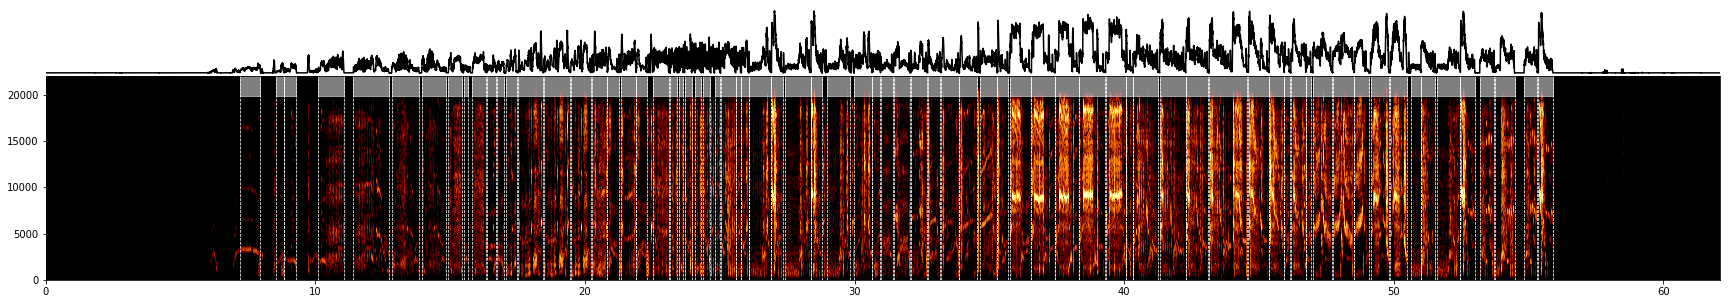

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/european_starling_gentner_segmented/2019-10-07_12-14-29/JSON/2017-11-11_18-28-46-050000.JSON False


Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f4ee01fa780>
Traceback (most recent call last):
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


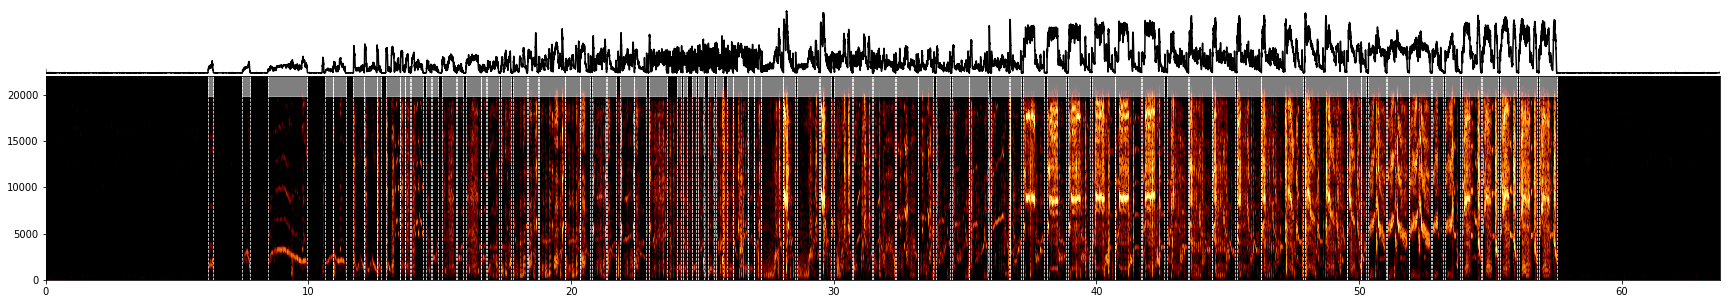

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s


/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/european_starling_gentner_segmented/2019-10-07_12-14-29/JSON/2017-11-12_17-19-52-700000.JSON False


KeyboardInterrupt: 

In [26]:
nex = 3
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]

    joblib.Parallel(n_jobs=1, verbose=11)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], plot=True, skip_existing=False) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

### Generate for full dataset

In [ ]:
nex = -1
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]

    joblib.Parallel(n_jobs=10, verbose=11)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], save=True, skip_existing=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

b1053


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:   11.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   11.9s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:   11.9s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:   11.9s
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=10)]: Done 151 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 152 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 153 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 155 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 156 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 157 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 159 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 162 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 163 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 164 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 165 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 166 tasks      | elapsed:  2.4min
[Paralle

[Parallel(n_jobs=10)]: Done 279 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 280 tasks      | elapsed:  5.2min
[Parallel(n_jobs=10)]: Done 281 tasks      | elapsed:  5.2min
[Parallel(n_jobs=10)]: Done 282 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 283 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 284 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 285 tasks      | elapsed:  5.4min
[Parallel(n_jobs=10)]: Done 286 tasks      | elapsed:  5.4min
[Parallel(n_jobs=10)]: Done 287 tasks      | elapsed:  5.4min
[Parallel(n_jobs=10)]: Done 288 tasks      | elapsed:  5.4min
[Parallel(n_jobs=10)]: Done 289 tasks      | elapsed:  5.5min
[Parallel(n_jobs=10)]: Done 290 tasks      | elapsed:  5.5min
[Parallel(n_jobs=10)]: Done 291 tasks      | elapsed:  5.5min
[Parallel(n_jobs=10)]: Done 292 tasks      | elapsed:  5.5min
[Parallel(n_jobs=10)]: Done 293 tasks      | elapsed:  5.5min
[Parallel(n_jobs=10)]: Done 294 tasks      | elapsed:  5.5min
[Paralle

[Parallel(n_jobs=10)]: Done 412 tasks      | elapsed:  8.7min
[Parallel(n_jobs=10)]: Done 413 tasks      | elapsed:  8.7min
[Parallel(n_jobs=10)]: Done 414 tasks      | elapsed:  8.7min
[Parallel(n_jobs=10)]: Done 415 tasks      | elapsed:  8.9min
[Parallel(n_jobs=10)]: Done 416 tasks      | elapsed:  9.0min
[Parallel(n_jobs=10)]: Done 417 tasks      | elapsed:  9.0min
[Parallel(n_jobs=10)]: Done 418 tasks      | elapsed:  9.1min
[Parallel(n_jobs=10)]: Done 419 tasks      | elapsed:  9.1min
[Parallel(n_jobs=10)]: Done 420 tasks      | elapsed:  9.2min
[Parallel(n_jobs=10)]: Done 421 tasks      | elapsed:  9.2min
[Parallel(n_jobs=10)]: Done 422 tasks      | elapsed:  9.2min
[Parallel(n_jobs=10)]: Done 423 tasks      | elapsed:  9.2min
[Parallel(n_jobs=10)]: Done 424 tasks      | elapsed:  9.2min
[Parallel(n_jobs=10)]: Done 425 tasks      | elapsed:  9.2min
[Parallel(n_jobs=10)]: Done 426 tasks      | elapsed:  9.3min
[Parallel(n_jobs=10)]: Done 427 tasks      | elapsed:  9.3min
[Paralle

b1060


[Parallel(n_jobs=10)]: Done 494 out of 494 | elapsed: 11.7min finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:   14.8s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:   19.9s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:   20.0s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:   20.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   20.4s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:   21.1s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:   22.2s
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=10)]: Done 132 tasks      | elapsed:  4.7min
[Parallel(n_jobs=10)]: Done 133 tasks      | elapsed:  4.7min
[Parallel(n_jobs=10)]: Done 134 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done 135 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done 137 tasks      | elapsed:  5.0min
[Parallel(n_jobs=10)]: Done 138 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 139 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 141 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 143 tasks      | elapsed:  5.2min
[Parallel(n_jobs=10)]: Done 144 tasks      | elapsed:  5.2min
[Parallel(n_jobs=10)]: Done 145 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 146 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 147 tasks      | elapsed:  5.3min
[Paralle

[Parallel(n_jobs=10)]: Done 265 tasks      | elapsed: 10.4min
[Parallel(n_jobs=10)]: Done 266 tasks      | elapsed: 10.4min
[Parallel(n_jobs=10)]: Done 267 tasks      | elapsed: 10.4min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed: 10.4min
[Parallel(n_jobs=10)]: Done 269 tasks      | elapsed: 10.4min
[Parallel(n_jobs=10)]: Done 270 tasks      | elapsed: 10.4min
[Parallel(n_jobs=10)]: Done 271 tasks      | elapsed: 10.5min
[Parallel(n_jobs=10)]: Done 272 tasks      | elapsed: 10.5min
[Parallel(n_jobs=10)]: Done 273 tasks      | elapsed: 10.5min
[Parallel(n_jobs=10)]: Done 274 tasks      | elapsed: 10.6min
[Parallel(n_jobs=10)]: Done 275 tasks      | elapsed: 10.6min
[Parallel(n_jobs=10)]: Done 276 tasks      | elapsed: 10.6min
[Parallel(n_jobs=10)]: Done 277 tasks      | elapsed: 10.6min
[Parallel(n_jobs=10)]: Done 278 tasks      | elapsed: 10.7min
[Parallel(n_jobs=10)]: Done 279 tasks      | elapsed: 10.7min
[Parallel(n_jobs=10)]: Done 280 tasks      | elapsed: 10.7min
[Paralle

In [ ]:
print('test')